## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import torch
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim


## 1. Load and Visualize a Sample Depth Image

Shape: (144, 256)


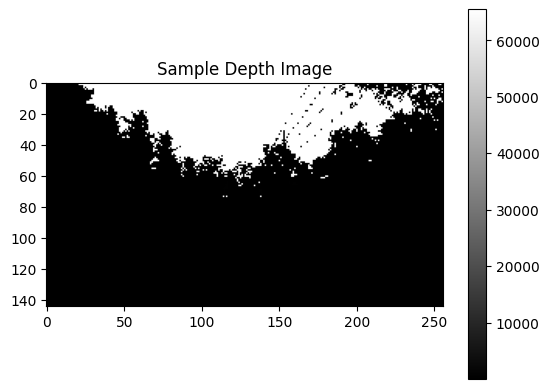

In [2]:
# Load one .npy file
depth = np.load("depth/depth_step_1.npy")

print("Shape:", depth.shape)  # Should be something like (144, 256)

# Visualize it
plt.imshow(depth, cmap="gray")
plt.colorbar()
plt.title("Sample Depth Image")
plt.show()

## 1.2 Normalize Data

In [3]:
class DepthMinMaxNormalize:
    def __call__(self, img):
        # img is a 2D NumPy array
        img = torch.tensor(img).float().unsqueeze(0)  # Shape: (1, H, W)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        return img

## 2. Preprocess the Images

In [4]:
# Example transform
transform = T.Compose([
    DepthMinMaxNormalize(),  # Normalize raw values to 0–1
    T.Resize((64, 64))       # Resize after normalization
])

# Apply transform
depth_tensor = transform(depth)
print(depth_tensor.shape)  # Should be (1, 64, 64)

torch.Size([1, 64, 64])


## 3. Build a PyTorch Dataset

In [5]:
class DepthDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.files = sorted([f for f in os.listdir(folder_path) if f.endswith(".npy")])
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, self.files[idx])
        depth = np.load(file_path)

        if self.transform:
            depth = self.transform(depth)

        return depth

## DataLoader Setup

In [6]:
# Folder containing .npy files
folder_path = "depth"  # Your folder name

# Reuse your transform from before
transform = T.Compose([
    T.ToTensor(),
    T.Resize((64, 64)),
    T.Normalize(mean=[0.5], std=[0.5])
])

# Create dataset and dataloader
dataset = DepthDataset(folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Test one batch
for batch in dataloader:
    print("Batch shape:", batch.shape)  # Should be [16, 1, 64, 64]
    break

Batch shape: torch.Size([16, 1, 64, 64])


## 4.1 Define the Encoder

In [7]:
class DepthEncoder(nn.Module):
    def __init__(self, out_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64 → 32x32
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32 → 16x16
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)),  # → 4x4
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, out_dim)
        )

    def forward(self, x):
        return self.encoder(x)

## 4.2 Define the Decoder

In [8]:
class DepthDecoder(nn.Module):
    def __init__(self, in_dim=128):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(in_dim, 64 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (64, 4, 4)),                # → [B, 64, 4, 4]
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # → [B, 32, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),  # → [B, 16, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=4),              # → [B, 1, 64, 64]
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

## 4.3 Combine into an Autoencoder

In [9]:
class DepthAutoencoder(nn.Module):
    def __init__(self, feature_dim=128):
        super().__init__()
        self.encoder = DepthEncoder(out_dim=feature_dim)
        self.decoder = DepthDecoder(in_dim=feature_dim)

    def forward(self, x):
        features = self.encoder(x)
        reconstruction = self.decoder(features)
        return reconstruction


## 4.4 Training Loop

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DepthAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

n_epochs = 10

for epoch in range(n_epochs):
    total_loss = 0
    model.train()
    for batch in dataloader:
        batch = batch.to(device)
        output = model(batch)
        loss = loss_fn(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(dataloader):.4f}")

Epoch 1 - Loss: 4924937920.0000
Epoch 2 - Loss: 5015252480.0000
Epoch 3 - Loss: 5058854656.0000
Epoch 4 - Loss: 5029727744.0000
Epoch 5 - Loss: 4971933184.0000
Epoch 6 - Loss: 5032954944.0000
Epoch 7 - Loss: 5057310080.0000
Epoch 8 - Loss: 4999222016.0000
Epoch 9 - Loss: 4972180352.0000
Epoch 10 - Loss: 5013794176.0000
